 # [Module 2.2] 타겟 인코딩 데이터를 사용하여 AutoGluon 훈련 및 추론

이 노트북은 기본으로 AutoGluon과 동일한 작업을 합니다.
- 데이터 로딩
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [1]:
import pandas as pd

In [2]:
%store -r te_auto_train_file
%store -r te_auto_test_file

In [3]:
te_auto_train_file

'preproc_data/fe/te_auto/train.csv'

## 데이터 로딩

In [4]:
train_pd = pd.read_csv(te_auto_train_file)
test_pd = pd.read_csv(te_auto_test_file)

In [5]:
print("auto_train_file: ", train_pd.shape)
print("auto_train_file: ", test_pd.shape)

auto_train_file:  (53740, 19)
auto_train_file:  (13436, 19)


In [6]:
from IPython.display import display as dp
dp(train_pd.head(2))
dp(test_pd.head(2))

,classes,price,freight_value,product_weight_g,product_volume,order_weekday,order_day,order_month,te_product_id_mean_smoothed,te_product_category_name_english_mean_smoothed,te_seller_state_mean_smoothed,te_seller_city_mean_smoothed,te_seller_zip_code_prefix_mean_smoothed,te_customer_seller_city_mean_smoothed,te_customer_seller_state_mean_smoothed,te_customer_seller_zip_code_prefix_mean_smoothed,te_customer_city_mean_smoothed,te_customer_state_mean_smoothed,te_customer_zip_code_prefix_mean_smoothed
0,3,29.99,10.96,9000.0,2640.0,1,4,10,2.138673,2.623823,2.112744,1.834408,1.725886,2.146831,1.631038,2.173256,2.291789,1.784604,2.216951
1,2,23.90,26.82,1500.0,14625.0,1,4,10,2.172449,2.220169,2.077027,2.222871,2.176866,2.151111,3.250278,2.193177,2.204278,3.168087,2.177346


,classes,price,freight_value,product_weight_g,product_volume,order_weekday,order_day,order_month,te_product_id_mean_smoothed,te_product_category_name_english_mean_smoothed,te_seller_state_mean_smoothed,te_seller_city_mean_smoothed,te_seller_zip_code_prefix_mean_smoothed,te_customer_seller_city_mean_smoothed,te_customer_seller_state_mean_smoothed,te_customer_seller_zip_code_prefix_mean_smoothed,te_customer_city_mean_smoothed,te_customer_state_mean_smoothed,te_customer_zip_code_prefix_mean_smoothed
0,3,105.00,23.89,1000.0,7632.0,1,19,6,2.378103,2.232840,2.195120,2.120438,2.711891,2.197809,2.173182,2.136937,2.609409,2.622631,2.183538
1,0,99.97,15.80,650.0,9600.0,1,19,6,2.197830,2.044144,2.379377,1.984575,2.149048,2.154301,2.228585,2.177672,1.633646,1.781283,2.163510


#### 에러 발생시 아래 처럼 수행
1. pip install autogluon
2. pip install --upgrade mxnet
3. from autogluon.tabular import TabularPrediction -> from autogluon import TabularPrediction 수정(실제로는 deprecate 된 api임)

In [7]:
# ! pip install autogluon
# # ! pip install --upgrade mxnet
# ! pip install mxnet==1.6.0

In [8]:
from autogluon.tabular import TabularPredictor as task

from autogluon.tabular import TabularDataset

## 오토글루온 데이터 타입으로 변경

In [9]:
import pandas
df = pd.read_csv(te_auto_train_file)
train_data = TabularDataset(df)
subsample_size = train_data.shape[0]
# subsample_size = 10000  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head(2))

       classes   price  freight_value  product_weight_g  product_volume  \
588          2   59.99          18.00             525.0          9280.0   
45386        3  120.00          18.72            1300.0          4864.0   

       order_weekday  order_day  order_month  te_product_id_mean_smoothed  \
588                0         30            1                     2.192629   
45386              4         27            4                     2.178141   

       te_product_category_name_english_mean_smoothed  \
588                                          2.150778   
45386                                        2.098091   

       te_seller_state_mean_smoothed  te_seller_city_mean_smoothed  \
588                         2.103136                      1.603601   
45386                       2.086446                      1.881213   

       te_seller_zip_code_prefix_mean_smoothed  \
588                                   1.742571   
45386                                 2.163687   

       t

In [10]:
label_column = 'classes'
print("Summary of class variable: \n", train_data[label_column].describe())

Summary of class variable: 
 count    53740.000000
mean         2.178675
std          1.152687
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: classes, dtype: float64


## 오토글루운으로 훈련

In [11]:
%%time
save_path_fe = 'advFE-agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
# presets = 'best_quality'
presets = 'medium_quality_faster_train'

predictor = task(label=label_column, 
                 path = save_path_fe).fit(train_data, 
        presets=presets,
                                                   excluded_model_types=['KNN','GBM','NN','FASTAI','RF']
                                                   )




Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "advFE-agModels-predictClass/"
AutoGluon Version:  0.2.0
Train Data Rows:    53740
Train Data Columns: 18
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [2, 3, 1, 0, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
NumExpr defaulting to 2 threads.
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1605.04 MB
	Train Data (Original)  Memory Usage: 7.74 MB (0.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dt

CPU times: user 2min 15s, sys: 1.81 s, total: 2min 17s
Wall time: 1min 23s


## 테스트 데이터 로딩

In [12]:
df_test = pd.read_csv(te_auto_test_file)

test_data = TabularDataset(df_test)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head(2))

    price  freight_value  product_weight_g  product_volume  order_weekday  \
0  105.00          23.89            1000.0          7632.0              1   
1   99.97          15.80             650.0          9600.0              1   

   order_day  order_month  te_product_id_mean_smoothed  \
0         19            6                     2.378103   
1         19            6                     2.197830   

   te_product_category_name_english_mean_smoothed  \
0                                        2.232840   
1                                        2.044144   

   te_seller_state_mean_smoothed  te_seller_city_mean_smoothed  \
0                       2.195120                      2.120438   
1                       2.379377                      1.984575   

   te_seller_zip_code_prefix_mean_smoothed  \
0                                 2.711891   
1                                 2.149048   

   te_customer_seller_city_mean_smoothed  \
0                               2.197809   
1      

## 모델 예측

In [14]:
prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.44231914260196487
Evaluations on test data:
{
    "accuracy": 0.44231914260196487,
    "balanced_accuracy": 0.424304151481511,
    "mcc": 0.2612216607977265
}


Predictions:   0        2
1        2
2        2
3        2
4        2
        ..
13431    0
13432    2
13433    2
13434    0
13435    0
Name: classes, Length: 13436, dtype: int64


## 리더 보드 생성

In [15]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.454376,0.4648,0.327608,0.036658,65.014134,0.327608,0.036658,65.014134,1,True,4
1,CatBoost,0.451623,0.4616,0.039552,0.006858,6.538092,0.039552,0.006858,6.538092,1,True,1
2,WeightedEnsemble_L2,0.442319,0.4740,1.703395,0.251912,77.093771,0.011349,0.000999,0.427333,2,True,5
3,ExtraTreesGini,0.432569,0.4424,0.403733,0.103762,2.325370,0.403733,0.103762,2.325370,1,True,2
4,ExtraTreesEntr,0.431304,0.4500,0.921153,0.103635,2.788842,0.921153,0.103635,2.788842,1,True,3


## 모델 평가

In [16]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.44%
f1_score: 0.42%


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/pylab/config.py:79: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


[[ 816  495  366   23    5]
 [ 285 1284 1762  745   86]
 [ 164  399 2497 1081  394]
 [  49  161  640 1111  207]
 [  15   49  293  274  235]]


<Figure size 432x288 with 0 Axes>

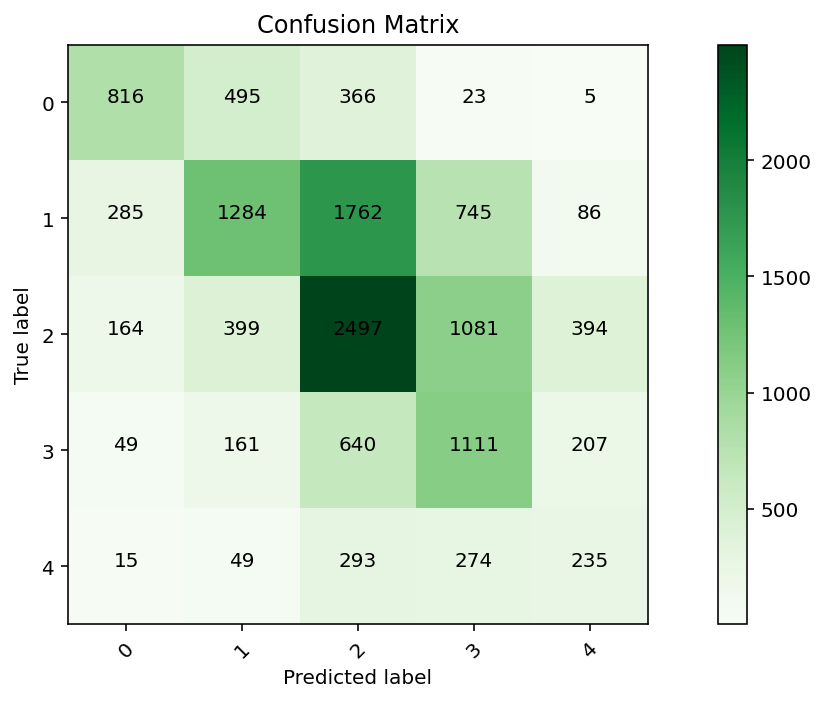

In [17]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

Computing feature importance via permutation shuffling for 18 features using 1000 rows with 3 shuffle sets...
	88.31s	= Expected runtime (29.44s per shuffle set)
	7.4s	= Actual runtime (Completed 3 of 3 shuffle sets)


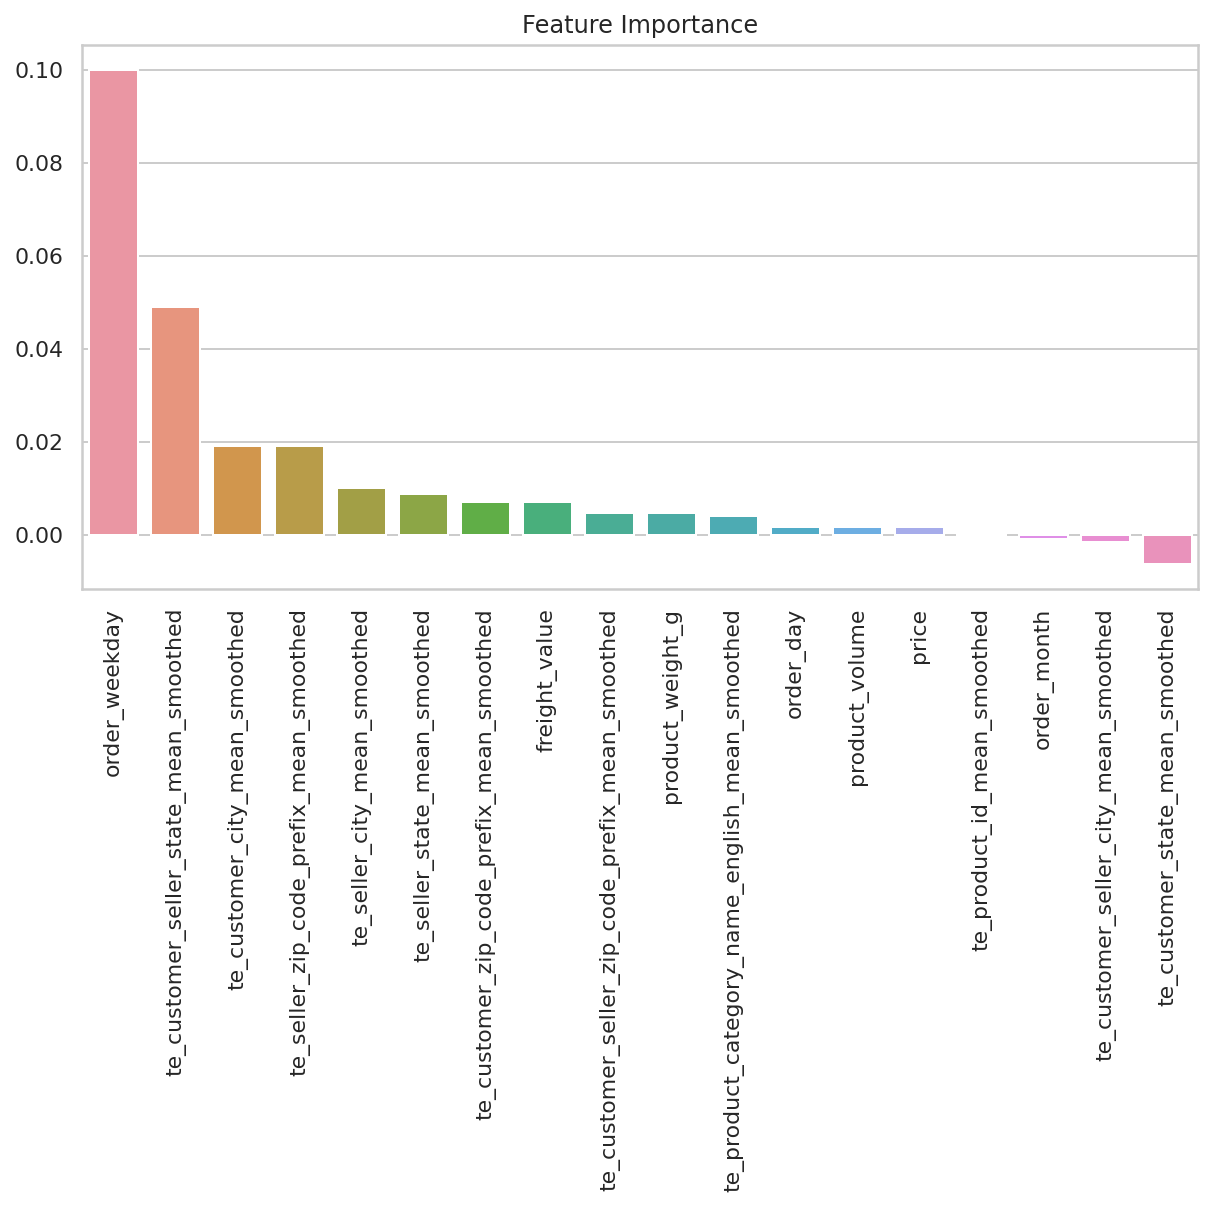

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

fea_imp = fea_importance['importance']

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_imp.index, y = fea_imp.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()